# Scrap IDR - USD Exchange Rate using BeautifulSoup

## Import Libraries

Several libraries that will be used in this project is: `requests` to establish a connection with source web, `BeatifulSoup` to scrapping, `Pandas` to create and process dataframes and `MathplotLib` to generate graph.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib as plt

## Requesting the Data and Creating a BeautifulSoup

In [2]:
url_get = requests.get('https://www.exchange-rates.org/history/IDR/USD/T')

To visualize what exactly we get from the `request.get`, we can use .content so we can see what we exactly get, in here We slice it until 300 first characters, so it won't make our screen full of the html we get from the page. You can delete the slicing if you want to see what we fully get.

In [3]:
url_get.content[:300]

b'\r\n<!DOCTYPE html>\r\n<!--[if lt IE 9]>\r\n    <html class="no-js ie8 oldie" lang=\'en\' xml:lang=\'en\'>\r\n<![endif]-->\r\n<!--[if gt IE 8]><!--> <html class="no-js" lang=\'en\' xml:lang=\'en\'> <!--<![endif]-->\r\n<head><title>Indonesian Rupiah Exchange Rate - US Dollar - Historical Exchange Rates</title>\n<meta htt'

As we can see we get a very unstructured and complex html, which actually contains the codes needed to show the webpages on  web browser. But as human, we still confused what and where we can use that piece of code, so here we use the beautifulsoup. Beautiful soup class will result a beautifulsoup object. Beautiful Soup transforms a complex HTML document into a complex tree of Python objects.

In [4]:
soup = BeautifulSoup(url_get.content, 'html.parser')

## Finding Right Key to Scrap and Extracting Data

![tbody](assets/tbody1.png)

Using `Inspect Elements` tool in our browser, we know that exchange rate data (table) are nested in `<tbody>`, so we pull it using `find` function

In [5]:
table = soup.find('tbody')

![tr](assets/tr.png)

Also, we know that each rows is nested in `tr` with attribute `class` and empty value, so to get all rows we pull all of them using `find_all` function

In [6]:
rows = table.find_all('tr', attrs={'class':''})

As we can see, the structure of each row in `tr` is like this:
```
<tr>
    <td>7/9/2021</td>
    <td>Friday</td>
    <td><a href="/Rate/USD/IDR/7-9-2021">14,499.31330</a> IDR</td>
    <td class="text-narrow-screen-hidden"><a href="/Rate/USD/IDR/7-9-2021">USD IDR rate for 7/9/2021</a></td>
</tr>
```
This means:
1. First `td` is date value
2. Second `td` is day name value
3. Third `td` is rate exchange value
4. Fourth `td` is additional information value

Remember that python is using [0] as first index, so by using slicing we can choose the value just we want

In [7]:
# Initialize empty list as container
temp = []

# Scrapping process
for i in range(0, len(rows)):
    row = rows[i]
    date = row.find_all('td')[0].text.strip()
    rate = row.find_all('td')[2].text.strip().replace(',','').replace('IDR','')

    # Store every data from scrap process in temp
    temp.append((date, rate))

To validate that we get what we want, we can look what exactly we got from the scrapping process by accesing `temp`

In [8]:
temp[:5]

[('7/9/2021', '14499.31330 '),
 ('7/8/2021', '14515.87714 '),
 ('7/7/2021', '14503.93654 '),
 ('7/6/2021', '14469.58258 '),
 ('7/5/2021', '14493.33968 ')]

Since we know that 'date' is ordered in ascending, we want to change the order to descending to make it easier to understand

In [9]:
temp = temp[::-1]

## Creating Data Frame & Data Wrangling

To create dataframe, we can use `DataFrame` function from `pandas`

In [10]:
df = pd.DataFrame(temp, columns=('Date', 'Rate'))

Check data type of dataframe

In [11]:
df.dtypes

Date    object
Rate    object
dtype: object

Currently, the type of all columns is `object`. We must change the data type accordingly, 'Date' must `datetime64` and 'Rate' must `float64`. If we look again, format of 'Date' if MM/DD/YYYY, so must handle it when converting do `datetime64`

In [12]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Rate'] = df['Rate'].astype('float')

Validate that data type is accordingly

In [13]:
df.dtypes

Date    datetime64[ns]
Rate           float64
dtype: object

Since we want to visualize the movement of 'Rate' over time, we need to set 'Date' as index

In [14]:
df = df.set_index('Date')

Now we can generate plot of the movement of 'Rate' over time

<AxesSubplot:xlabel='Date'>

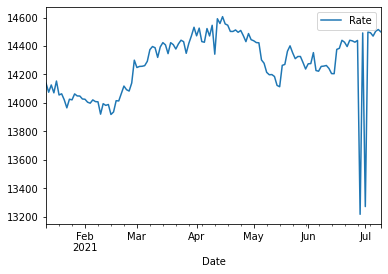

In [15]:
df.plot.line()

In [16]:
df.describe()

,Rate
count,130.000000
mean,14274.325339
std,223.515777
min,13215.840520
25%,14119.257335
50%,14315.389400
75%,14434.925677
max,14606.528450


In [17]:
df[df['Rate'] == df['Rate'].min()]

,Rate
Date,
2021-06-29,13215.84052


In [18]:
df[df['Rate'] == df['Rate'].max()]

,Rate
Date,
2021-04-15,14606.52845


## Anlysis

IDR-USD exchange rate is very volatile. The average of exchange rate is IDR 14,272.32 per USD with standard deviation 223.51 IDR. The highest point are IDR 14,606.53 per USD at 15th April 2021, and the lowest point are IDR 13,215.84 at 29th June 2021.